In [1]:
import os
import random
import copy
import time

import torch 
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage
from PIL import Image, ImageEnhance, ImageOps

from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms, utils
import torchvision.datasets as datasets

data_dir = 'data'

train_dir = os.path.join(data_dir, 'train')
train_class = os.path.join(data_dir, 'train.csv')

val_dir = os.path.join(data_dir, 'val')
val_class = os.path.join(data_dir, 'val.csv')

test_dir = os.path.join(data_dir, 'test')
test_meta = os.path.join(data_dir, 'test.csv')

image_data = {'train':train_dir, 'val':val_dir, 'test':test_dir}
label_data = {'train':train_class, 'val':val_class, 'test':test_meta}

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
class Melanoma(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        skin_labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.img_ids = list(skin_labels['image_id'])
        self.labels = list(skin_labels['target'])
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.img_ids[idx])
        image = Image.open(img_name + '.jpg')
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
class AutoAugment(object):
    def __init__(self):
        self.policies = [
            ['Invert', 0.1, 7, 'Contrast', 0.2, 6],
            ['Rotate', 0.7, 2, 'TranslateX', 0.3, 9],
            ['Sharpness', 0.8, 1, 'Sharpness', 0.9, 3],
            ['ShearY', 0.5, 8, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.5, 8, 'Equalize', 0.9, 2],
            ['ShearY', 0.2, 7, 'Posterize', 0.3, 7],
            ['Color', 0.4, 3, 'Brightness', 0.6, 7],
            ['Sharpness', 0.3, 9, 'Brightness', 0.7, 9],
            ['Equalize', 0.6, 5, 'Equalize', 0.5, 1],
            ['Contrast', 0.6, 7, 'Sharpness', 0.6, 5],
            ['Color', 0.7, 7, 'TranslateX', 0.5, 8],
            ['Equalize', 0.3, 7, 'AutoContrast', 0.4, 8],
            ['TranslateY', 0.4, 3, 'Sharpness', 0.2, 6],
            ['Brightness', 0.9, 6, 'Color', 0.2, 8],
            ['Solarize', 0.5, 2, 'Invert', 0, 0.3],
            ['Equalize', 0.2, 0, 'AutoContrast', 0.6, 0],
            ['Equalize', 0.2, 8, 'Equalize', 0.6, 4],
            ['Color', 0.9, 9, 'Equalize', 0.6, 6],
            ['AutoContrast', 0.8, 4, 'Solarize', 0.2, 8],
            ['Brightness', 0.1, 3, 'Color', 0.7, 0],
            ['Solarize', 0.4, 5, 'AutoContrast', 0.9, 3],
            ['TranslateY', 0.9, 9, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.9, 2, 'Solarize', 0.8, 3],
            ['Equalize', 0.8, 8, 'Invert', 0.1, 3],
            ['TranslateY', 0.7, 9, 'AutoContrast', 0.9, 1],
        ]

    def __call__(self, img):
        img = apply_policy(img, self.policies[random.randrange(len(self.policies))])
        return img

In [5]:
operations = {
    'ShearX': lambda img, magnitude: shear_x(img, magnitude),
    'ShearY': lambda img, magnitude: shear_y(img, magnitude),
    'TranslateX': lambda img, magnitude: translate_x(img, magnitude),
    'TranslateY': lambda img, magnitude: translate_y(img, magnitude),
    'Rotate': lambda img, magnitude: rotate(img, magnitude),
    'AutoContrast': lambda img, magnitude: auto_contrast(img, magnitude),
    'Invert': lambda img, magnitude: invert(img, magnitude),
    'Equalize': lambda img, magnitude: equalize(img, magnitude),
    'Solarize': lambda img, magnitude: solarize(img, magnitude),
    'Posterize': lambda img, magnitude: posterize(img, magnitude),
    'Contrast': lambda img, magnitude: contrast(img, magnitude),
    'Color': lambda img, magnitude: color(img, magnitude),
    'Brightness': lambda img, magnitude: brightness(img, magnitude),
    'Sharpness': lambda img, magnitude: sharpness(img, magnitude),
    'Cutout': lambda img, magnitude: cutout(img, magnitude),
}

In [6]:
def apply_policy(img, policy):
    if random.random() < policy[1]:
        img = operations[policy[0]](img, policy[2])
    if random.random() < policy[4]:
        img = operations[policy[3]](img, policy[5])

    return img


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = offset_matrix @ matrix @ reset_matrix
    return transform_matrix


def shear_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img

def shear_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [0, 1, img.shape[1]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img

def rotate(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-30, 30, 11)
    theta = np.deg2rad(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    transform_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img

In [7]:
def auto_contrast(img, magnitude):
    img = ImageOps.autocontrast(img)
    return img


def invert(img, magnitude):
    img = ImageOps.invert(img)
    return img


def equalize(img, magnitude):
    img = ImageOps.equalize(img)
    return img


def solarize(img, magnitude):
    magnitudes = np.linspace(0, 256, 11)
    img = ImageOps.solarize(img, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def posterize(img, magnitude):
    magnitudes = np.linspace(4, 8, 11)
    img = ImageOps.posterize(img, int(round(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))))
    return img


def contrast(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Contrast(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def color(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Color(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def brightness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Brightness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def sharpness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Sharpness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img

In [8]:
def cutout(org_img, magnitude=None):
    img = np.array(img)

    magnitudes = np.linspace(0, 60/331, 11)

    img = np.copy(org_img)
    mask_val = img.mean()

    if magnitude is None:
        mask_size = 16
    else:
        mask_size = int(round(img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])))
    top = np.random.randint(0 - mask_size//2, img.shape[0] - mask_size)
    left = np.random.randint(0 - mask_size//2, img.shape[1] - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    if top < 0:
        top = 0
    if left < 0:
        left = 0

    img[top:bottom, left:right, :].fill(mask_val)

    img = Image.fromarray(img)

    return img



class Cutout(object):
    def __init__(self, length=16):
        self.length = length

    def __call__(self, img):
        img = np.array(img)

        mask_val = img.mean()

        top = np.random.randint(0 - self.length//2, img.shape[0] - self.length)
        left = np.random.randint(0 - self.length//2, img.shape[1] - self.length)
        bottom = top + self.length
        right = left + self.length

        top = 0 if top < 0 else top
        left = 0 if left < 0 else top

        img[top:bottom, left:right, :] = mask_val

        img = Image.fromarray(img)

        return img

In [9]:
def compute_class_weights(labels, nclasses):                        
    count = [0] * nclasses
    for label in labels: 
        count[int(label)] += 1
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                              
    weight = [0] * len(labels)                                            
    for idx, val in enumerate(labels):                                          
        weight[idx] = weight_per_class[int(val)]                                  
    return weight    

In [10]:
train_file = os.path.join(data_dir, 'train.pth')
val_file = os.path.join(data_dir, 'val.pth')

if os.path.isfile(train_file):
    train_dataset = torch.load(train_file)
else:
    train_dataset = Melanoma(label_data['train'], image_data['train'], 
                             transform=data_transforms['train'])
    torch.save(train_dataset, train_file)
    
if os.path.isfile(val_file):
    val_dataset = torch.load(val_file)
else:
    val_dataset = Melanoma(label_data['val'], image_data['val'], 
                           transform=data_transforms['val'])
    torch.save(val_dataset, val_file)

weights = compute_class_weights(train_dataset.labels, 2)                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = WeightedRandomSampler(weights, len(weights))

train_dataloader = DataLoader(train_dataset, batch_size=10, sampler=sampler, 
                              num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False, 
                            num_workers=0, pin_memory=True)

print("Finish Loading Datasets")
print("Number of training images: ", len(train_dataset))
print("Number of testing images: ", len(val_dataset))

Finish Loading Datasets
Number of training images:  61600
Number of testing images:  750


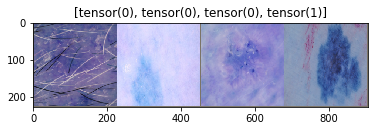

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=list(classes[:4]))

In [ ]:
def crop_microscope(img_to_crop):
    pad_y = img_to_crop.shape[0] // 200 
    pad_x = img_to_crop.shape[1] //200
    img = img_to_crop[pad_y:-pad_y, pad_y:-pad_y,:]
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,50,255,cv2.THRESH_BINARY) 
    x,y,w,h = cv2.boundingRect(thresh) 
    
    if y!=0: 
        y = y+pad_y
    if h == thresh.shape[0]:
        h = h+pad_y
    if x !=0:
        x = x +pad_x
    if w == thresh.shape[1]:
        w = w + pad_x
    h = h+pad_y
    w = w + pad_x
    crop = img_to_crop[y:y+h,x:x+w]
    return crop

In [ ]:
plt.figure(figsize = (20,70))

for i in range (len(pathes)):
    img = Image.open(pathes[i])
    img = np.array(img)
   
    plt.figure(figsize = (10,35))
    plt.imshow(img)
    
    plt.subplot(len(pathes), 2, i*2+1)
    plt.imshow(crop_microscope(img))
    
    plt.title(f'Cropped shape: {crop_microscope(img).shape}', fontsize = 20)
    plt.subplot(len(pathes),2,i*2+2)
    
    plt.imshow(img)
    plt.title(f'Original shape: {img.shape}', fontsize=20)

In [12]:
model_parms = {
    'optimizer': 'Adam',
    'criterion': 'CrossEntropy',
    'model': 'EfficientNet',
}

In [13]:
resnet = models.resnet18(pretrained=True)
n_features = resnet.fc.in_features
resnet.fc = nn.Linear(n_features, 100)
'''model = nn.Sequential(OrderedDict([
          ('ResNet18', resnet),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(100, 2)),
          ('sigmoid', nn.sigmoid())
        ]))'''

model = nn.Sequential(
            resnet,
            nn.ReLU(),
            nn.Linear(100, 2))

In [14]:
from efficientnet_pytorch import EfficientNet

def efficientnet_b1():
    return EfficientNet.from_pretrained('efficientnet-b1',num_classes=2)

def efficientnet_b2():
    return EfficientNet.from_pretrained('efficientnet-b2',num_classes=2)

def efficientnet_b3():
    return EfficientNet.from_pretrained('efficientnet-b3',num_classes=2)

def efficientnet_b4():
    return EfficientNet.from_pretrained('efficientnet-b4',num_classes=2)

def efficientnet_b5():
    return EfficientNet.from_pretrained('efficientnet-b5',num_classes=2)       

def efficientnet_b6():
    return EfficientNet.from_pretrained('efficientnet-b6',num_classes=2)   

def efficientnet_b7():
    return EfficientNet.from_pretrained('efficientnet-b7',num_classes=2)

In [15]:
model = efficientnet_b7()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
dataloaders = {'train':train_dataloader, 'val':val_dataloader}

Loaded pretrained weights for efficientnet-b7


In [26]:
import time 
import copy
from barbar import Bar

dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in Bar(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.sigmoid(model(inputs))
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            checkpoint = {
                'model': model.state_dict(),
                'accuracy': epoch_acc,
                'epoch': epoch
            }
            torch.save(checkpoint, '%s.pt' % os.path.join('checkpoints', 'checkpoint'))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                checkpoint = {
                    'model': model.state_dict(),
                    'accuracy': best_acc,
                    'epoch': epoch
                }

                print('New optimum found, saving checkpoint now...')
                torch.save(checkpoint, '%s.pt' % os.path.join('checkpoints', 'best_model'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
750/750: [===============================>] - ETA 4.8sss
train Loss: 0.0055 Acc: 0.0106
750/750: [===============================>] - ETA 3.7sss
val Loss: 0.5097 Acc: 0.8040
New optimum found, saving checkpoint now...

Epoch 1/2
----------
750/750: [===============================>] - ETA 4.8sss
train Loss: 0.0062 Acc: 0.0098
750/750: [===============================>] - ETA 3.8sss
val Loss: 0.5094 Acc: 0.8040

Epoch 2/2
----------
750/750: [===============================>] - ETA 4.5sss
train Loss: 0.0062 Acc: 0.0098
750/750: [===============================>] - ETA 3.7sss
val Loss: 0.5093 Acc: 0.8040

Training complete in 34m 29s
Best val Acc: 0.804000


In [ ]:
model.load_state_dict(torch.load('%s.pt' % os.path.join('checkpoints', 'best_model'))['model'])
model.eval()
running_loss = 0.0
running_corrects = 0

for inputs, labels in Bar(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() 

    with torch.set_grad_enabled(False):
        outputs = torch.sigmoid(model(inputs))
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
    if torch.sum(labels.data) > 0:
        print('\n')
        print(preds)
        print(labels.data)
        print('\n')

epoch_loss = running_loss / dataset_sizes[phase]
epoch_acc = running_corrects.double() / dataset_sizes[phase]

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)